In [1]:
import sqlite3
import pandas as pd
import numpy as np
import time
import pickle
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize.moses import MosesDetokenizer
from stop_words import get_stop_words
from collections import defaultdict
import gensim
from gensim import corpora, models, similarities
from gensim.models.doc2vec import TaggedDocument,TaggedLineDocument
from gensim.models import Doc2Vec
import gensim.models.doc2vec
from random import randint 
from IPython.display import Image
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

In [12]:
conn = sqlite3.connect("volume2/testDB.db")
df = pd.read_sql('SELECT doi,title,editors,abstract from PLOS_ALL', conn)

In [19]:
df.head()

,doi,title,editors,abstract
0,10.1371/journal.pone.0143437,Distribution Features of Skeletal Metastases: ...,['Harriet Wikman'],Bone scintigraphies are widely applied for det...
1,10.1371/journal.pone.0096769,Voice Disorder in Cystic Fibrosis Patients,['Donald A. Robin'],Cystic fibrosis common autosomal recessive d...
2,10.1371/journal.pone.0177044,Comorbidity and progression of late onset Alzh...,['Stephen D. Ginsberg'],Alzheimer’ disease neurodegenerative syndrom...
3,10.1371/journal.pone.0033200,Effect of Polymorphisms in,['Alfons Navarro'],PurposeXeroderma pigmentosum group (XPD) code...
4,10.1371/journal.pone.0001814,Anchor Side Chains of Short Peptide Fragments ...,['Mauricio Martins Rodrigues'],Class MHC molecules display peptides the cel...


In [3]:
# Load saved model files
# lsi = models.LsiModel.load('volume2/new_models/body_model.lsi')
# lda = models.LdaModel.load('volume2/new_models/body_model.lda')
# tfidf = models.TfidfModel.load('volume2/new_models/body_model.tfidf')
# index = similarities.MatrixSimilarity.load('volume2/new_models/body_similarity.index')
# corpus = corpora.MmCorpus('volume2/new_models/body_corpus.mm')
# dictionary = corpora.Dictionary.load('volume2/new_models/body_dictionary.dict')
# model = Doc2Vec.load('volume2/new_models/body_features-w2v-200.doc2vec')

In [24]:
# Load saved model files
lsi = models.LsiModel.load('volume/models/model.lsi')
lda = models.LdaModel.load('volume/models/model.lda')
tfidf = models.TfidfModel.load('volume/models/model.tfidf')
index = similarities.MatrixSimilarity.load('volume/models/similarity.index')
corpus = corpora.MmCorpus('volume/models/corpus.mm')
dictionary = corpora.Dictionary.load('volume/models/dictionary.dict')
model = Doc2Vec.load('volume/models/features-w2v-200.doc2vec')

In [25]:
# Transform corpus
corpus_tfidf = tfidf[corpus]
corpus_lsi = lsi[corpus_tfidf]
corpus_lda = lda[corpus_tfidf]

### Topic Modeling (LSA / LDA)

Topic modeling is a technique for the discovery of hidden (or "latent") semantic structures in a corpus. Each document is described in terms of one or more "topics," which are made up of the most common words in that topic. These unobserved semantic relationships can be used to ascertain similarity between documents. Topic weights can also be used as inputs for other analysis methods, like association rule learning.

#### Print 5 random topics

In [13]:
print('LSI Topics')
print()
for i in range(0,5):
    x = randint(0,200)
    print('Topic ' + str(x) + ': ' + lsi.print_topic(x))
    print()

print('---------')
print()
print('LDA Topics')
print()
for i in range(0,6):
    x = randint(0,200)
    print('Topic ' + str(x) + ': ' + lda.print_topic(x))
    print()

LSI Topics

Topic 22: -0.279*"il" + -0.267*"model" + -0.202*"express" + -0.201*"speci" + -0.201*"strain" + 0.190*"t" + -0.177*"s" + 0.147*"mir" + 0.145*"time" + 0.144*"n"

Topic 90: -0.213*"mutant" + 0.192*"gfp" + 0.189*"mutat" + -0.159*"data" + 0.150*"soil" + 0.148*"trial" + 0.147*"number" + -0.142*"rate" + -0.138*"resist" + -0.137*"growth"

Topic 75: 0.365*"l" + -0.335*"cluster" + -0.218*"mutant" + 0.207*"type" + 0.185*"imag" + 0.168*"data" + 0.150*"soil" + -0.149*"d" + -0.149*"human" + 0.125*"mutat"

Topic 193: 0.226*"year" + -0.171*"cd4" + -0.167*"factor" + -0.163*"forest" + 0.149*"method" + -0.144*"estim" + 0.130*"follow" + 0.130*"distribut" + 0.123*"parasit" + -0.108*"temperatur"

Topic 154: -0.250*"dc" + -0.198*"non" + -0.178*"select" + -0.177*"size" + 0.172*"women" + 0.164*"score" + 0.143*"receptor" + -0.139*"case" + -0.137*"x" + -0.134*"growth"

---------

LDA Topics

Topic 83: 0.196*"blood" + 0.048*"plasma" + 0.031*"platelet" + 0.024*"mp" + 0.021*"count" + 0.020*"rbc" + 0.019

In [7]:
# ## Abstracts LSI
# ab_lsi = models.LsiModel.load('volume/models/model.lsi')

# print('LSI Topics')
# print()
# for i in range(0,5):
#     x = randint(0,200)
#     print('Topic ' + str(x) + ': ' + ab_lsi.print_topic(x))
#     print()

#### Show topic weights of a given document

In [17]:
# Get a DOI
x = randint(0,200)
df.loc[x]['doi']

'10.1371/journal.pone.0027532'

In [26]:
doi_in = input('Enter a DOI: ')
qu_doi = df.loc[df['doi']==doi_in].index[0]
print('Title:',df.loc[qu_doi]['title'])
print()
topics = lda.get_document_topics(corpus[qu_doi],minimum_probability=.05)
topics = sorted(topics,key=lambda x: x[1],reverse=True)
print('Topic Weights:')
print(sorted(topics,key=lambda x: x[1],reverse=True))
print()
for i in range(5):
    print('Topic ' + str(topics[i][0]) + ': ')
    [print(x[0]) for x in lda.show_topic(topics[i][0])]
    print()


Title: Measurement of Phospholipids May Improve Diagnostic Accuracy in Ovarian Cancer

Topic Weights:
[(148, 0.18252061), (43, 0.13973618), (97, 0.13704967), (161, 0.07686245), (25, 0.065142386)]

Topic 148: 
measur
valid
correl
use
assess
discrimin
reliabl
biomark
test
specif

Topic 43: 
model
predict
data
use
method
estim
base
approach
set
statist

Topic 97: 
cancer
lung
prostat
donovani
kaposi
colorect
gastric
pancreat
daughter
associ

Topic 161: 
hospit
complic
surgeri
center
case
surgic
congenit
oper
procedur
seek

Topic 25: 
detect
use
test
method
sampl
sensit
assay
diagnost
result
can



#### Most similar documents given doi

In [30]:
# 10.1371/journal.pone.0046846

query_doi = input('Enter a DOI: ')
query_doc = df.loc[df['doi']==query_doi].index[0]
doc_bow = corpus[query_doc]

vec_lsi = lsi[doc_bow]
lsi_sims = sorted(enumerate(index[vec_lsi]), key=lambda item: -item[1])
simdocs_lsi = [x[0] for x in lsi_sims[1:11]]

vec_lda = lda[doc_bow]
lda_sims = sorted(enumerate(index[vec_lda]), key=lambda item: -item[1])
simdocs_lda = [x[0] for x in lda_sims[0:10]]

print('Target: ' + df.loc[query_doc,'title'])
print('')
print('LSI Most Similar Documents:')
for i in range(0,len(simdocs_lsi)):
    print(str(i+1) + '. ' + df.loc[simdocs_lsi[i],'title'])
    print(str(i+1) + '. ' + df.loc[simdocs_lsi[i],'editors'])

Target: Measurement of Phospholipids May Improve Diagnostic Accuracy in Ovarian Cancer

LSI Most Similar Documents:
1. Development and Preliminary Evaluation of a Multivariate Index Assay for Ovarian Cancer
1. ['Ewout W. Steyerberg']
2. Systematic Evaluation of Candidate Blood Markers for Detecting Ovarian Cancer
2. ['Michael Goodyear']
3. Effects of Blood Collection Conditions on Ovarian Cancer Serum Markers
3. ['Alice Rumbold']
4. Knowledge about Cervical Cancer and Associated Factors among 15-49 Year Old Women in Dessie Town, Northeast Ethiopia
4. ['Dimitrios Paraskevis']
5. Comprehensive Serum Profiling for the Discovery of Epithelial Ovarian Cancer Biomarkers
5. ['Xin-yuan Guan']
6. Identification of BRCA1 Deficiency Using Multi-Analyte Estimation of BRCA1 and Its Repressors in FFPE Tumor Samples from Patients with Triple Negative Breast Cancer
6. ['Anna Sapino']
7. An HR-MAS MR Metabolomics Study on Breast Tissues Obtained with Core Needle Biopsy
7. ['Daniel Monleon']
8. Developm

In [23]:
type(vec_lsi)

list

In [9]:
lsi_sims[:6]

[(111, 1.0),
 (19833, 0.70308983),
 (40728, 0.6707456),
 (106207, 0.60060215),
 (114995, 0.6002796),
 (131349, 0.5978229)]

In [12]:
V = gensim.matutils.corpus2dense(lsi[corpus_lsi], len(lsi.projection.s)).T / lsi.projection.s

In [13]:
V.shape

(218717, 200)

In [17]:
pca = PCA(n_components=3)
pca_mat = pca.fit_transform(V)

In [20]:
pca_mat[111]

array([ 2.55879845e-04,  2.93725218e-04, -8.13625029e-05])

In [21]:
pca_mat[19833]

array([2.51780156e-04, 3.05122714e-04, 2.11229124e-05])

In [36]:
pca_mat[129432][2]


0.00012270659295905988

NameError: name 'pca_mat' is not defined

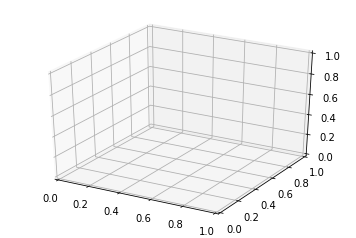

In [11]:


fig = plt.figure()
ax = fig.gca(projection='3d')
x = [0,pca_mat[111][0]]
y = [0,pca_mat[111][1]]
z = [0,pca_mat[111][2]]

x1 = [0,pca_mat[19833][0]]
y1 = [0,pca_mat[19833][1]]
z1 = [0,pca_mat[19833][2]]

x2 = [0,pca_mat[129432][0]]
y2 = [0,pca_mat[129432][1]]
z2 = [0,pca_mat[129432][2]]

ax.plot(x, y, z, label='Target')
ax.plot(x1, y1, z1, label='Most Similar')
ax.plot(x2, y2, z2, label='Dissimilar')
ax.legend()

plt.show()

In [19]:
pca2 = PCA(n_components=2)
pca_mat2 = pca2.fit_transform(V)

In [20]:
x = [0,pca_mat2[111][0]]
y = [0,pca_mat2[111][1]]

x1 = [0,pca_mat2[19833][0]]
y1 = [0,pca_mat2[19833][1]]

x2 = [0,pca_mat2[127171][0]]
y2 = [0,pca_mat2[127171][1]]

In [21]:
print(df.loc[lsi_sims[1002][0],'title'])
print(df.loc[lsi_sims[0][0],'title'])
print(df.loc[lsi_sims[1][0],'title'])
lsi_sims[1002][0]

Facial Features: What Women Perceive as Attractive and What Men Consider Attractive
Measurement of Phospholipids May Improve Diagnostic Accuracy in Ovarian Cancer
Development and Preliminary Evaluation of a Multivariate Index Assay for Ovarian Cancer


127171

/home/ubuntu/.local/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


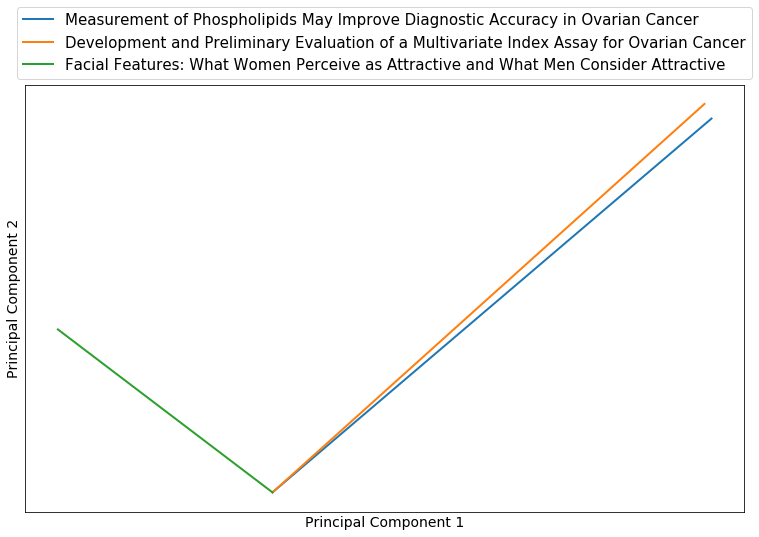

In [23]:
plt.figure(figsize=(12,8))
# plt.rcParams['legend.fontsize'] = 15
# plt.rcParams['font.family'] = 'Serif'
plt.rcParams['font.size'] = 14

plt.plot(x,y,linewidth=2, label='Measurement of Phospholipids May Improve Diagnostic Accuracy in Ovarian Cancer')
plt.plot(x1,y1,linewidth=2, label='Development and Preliminary Evaluation of a Multivariate Index Assay for Ovarian Cancer')
plt.plot(x2,y2,linewidth=2, label='Facial Features: What Women Perceive as Attractive and What Men Consider Attractive')
plt.ylabel('Principal Component 2')
plt.xlabel('Principal Component 1')
plt.legend(loc='upper center', bbox_to_anchor=(0., 1., 1., .2),prop={'size': 15})

plt.tight_layout()
plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
#plt.show()
plt.savefig('pca.png',dpi=600)
#plt.savefig('pca_sm.png')

#### Most similar documents given search query (or abstract)

In [17]:
# Search treats the query as another document -- which links it to topics and the hidden semantic
# structures of the text. Then returns similarly topic weighted results. 

doc = input('Enter a search query: ')

vec_bow = dictionary.doc2bow(doc.lower().split())
vec_lsi = lsi[vec_bow] # convert the query to LSI space
lsi_sims = sorted(enumerate(index[vec_lsi]), key=lambda item: -item[1])
simdocs_lsi = [x[0] for x in lsi_sims[0:10]]

for i in range(0,len(simdocs_lsi)):
    print(str(i+1) + '. ' + df.loc[simdocs_lsi[i],'title'])

1. Ten-Year Mortality after a Breast Cancer Diagnosis in Women with Severe Mental Illness: A Danish Population-Based Cohort Study
2. Breast Cancer Biology and Ethnic Disparities in Breast Cancer Mortality in New Zealand: A Cohort Study
3. Factors Associated with Uptake of Visual Inspection with Acetic Acid (VIA) for Cervical Cancer Screening in Western Kenya
4. Knowledge about Cervical Cancer and Associated Factors among 15-49 Year Old Women in Dessie Town, Northeast Ethiopia
5. Relationship between Cancer Worry and Stages of Adoption for Breast Cancer Screening among Korean Women
6. Women Commencing Anastrozole, Letrozole or Tamoxifen for Early Breast Cancer: The Impact of Comorbidity and Demographics on Initial Choice
7. Socio-Demographic and Geographical Factors in Esophageal and Gastric Cancer Mortality in Sweden
8. Black and White Women in Maryland Receive Different Treatment for Cervical Cancer
9. Innate Immunity Pathways and Breast Cancer Risk in African American and European-Am

### Word Embedding

Word Embedding is a neural network model to represent words and documents as numerical vectors. The goal is to learn word representations that can predict a document given its surrounding words and documents. This allows context to play a much larger role in document grouping, and thus potentially giving better querying results.

#### What are most and least similar to a given article?

In [9]:
#doc_id = np.random.randint(model.docvecs.count) 
query_doi = input('Enter a DOI: ')
doc_id = df.loc[df['doi']==query_doi].index[0]

sims = model.docvecs.most_similar(doc_id, topn=model.docvecs.count)  # get *all* similar documents
print(u'TARGET (%d): %s' % (doc_id, ''.join(df.loc[doc_id]['title'])))
print(df.loc[sims[0][0]]['doi'])
print()

for label, index in [('MOST', 0), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: %s' % (label, sims[index], ''.join(df.loc[sims[index][0]]['title'])))
    print(df.loc[sims[index][0]]['doi'])
    print()

TARGET (111): Measurement of Phospholipids May Improve Diagnostic Accuracy in Ovarian Cancer
10.1371/journal.pone.0151590

MOST (71029, 0.4707134962081909): REG4 Is Highly Expressed in Mucinous Ovarian Cancer: A Potential Novel Serum Biomarker
10.1371/journal.pone.0151590

LEAST (190109, -0.31195080280303955): Speeding up Microevolution: The Effects of increasing Temperature on Selection and Genetic Variance in a Wild Bird Population
10.1371/journal.pbio.1001015



In [40]:
sims = model.docvecs.most_similar(doc_id, topn=10)
simdocs = [x[0] for x in sims]
simdocs
pd.set_option('display.max_colwidth', -1)
df.loc[simdocs][['doi', 'title', 'editors']]

,doi,title,editors
71029,10.1371/journal.pone.0151590,REG4 Is Highly Expressed in Mucinous Ovarian Cancer: A Potential Novel Serum Biomarker,['Kwong-Kwok Wong']
17076,10.1371/journal.pone.0150253,Prostate Cancer Associated Lipid Signatures in Serum Studied by ESI-Tandem Mass Spectrometryas Potential New Biomarkers,['Mohammad Saleem']
180667,10.1371/journal.pone.0160505,New Biochemical Insights into the Mechanisms of Pulmonary Arterial Hypertension in Humans,['Daniel Monleon']
203798,10.1371/journal.pmed.1002063,Improving Clinical Risk Stratification at Diagnosis in Primary Prostate Cancer: A Prognostic Modelling Study,['Andrew H. Beck']
137424,10.1371/journal.pone.0053141,Circulating microRNAs as Specific Biomarkers for Breast Cancer Detection,['Rakesh K. Srivastava']
80687,10.1371/journal.pone.0166067,Immunohistochemical Typing of Adenocarcinomas of the Pancreatobiliary System Improves Diagnosis and Prognostic Stratification,['Francisco X. Real']
185136,10.1371/journal.pone.0121112,Validation of LRG1 as a Potential Biomarker for Detection of Epithelial Ovarian Cancer by a Blinded Study,['Anthony W.I. Lo']
23073,10.1371/journal.pone.0102144,Hemoglobin A1c for Diagnosis of Postpartum Abnormal Glucose Tolerance among Women with Gestational Diabetes Mellitus: Diagnostic Meta-Analysis,['Irun R. Cohen']
107092,10.1371/journal.pone.0147214,Improved Pancreatic Adenocarcinoma Diagnosis in Jaundiced and Non-Jaundiced Pancreatic Adenocarcinoma Patients through the Combination of Routine Clinical Markers Associated to Pancreatic Adenocarcinoma Pathophysiology,['Hans A Kestler']
16664,10.1371/journal.pone.0145545,Improving the Prediction of Prostate Cancer Overall Survival by Supplementing Readily Available Clinical Data with Gene Expression Levels of IGFBP3 and F3 in Formalin-Fixed Paraffin Embedded Core Needle Biopsy Material,['Kin Mang Lau']


In [14]:
sims

[(71029, 0.4707134962081909),
 (17076, 0.4682629108428955),
 (180667, 0.4672335982322693),
 (203798, 0.4643259048461914),
 (137424, 0.43628954887390137),
 (80687, 0.4348726272583008),
 (185136, 0.4345966875553131),
 (23073, 0.434241384267807),
 (107092, 0.43370217084884644),
 (16664, 0.4286631941795349)]

### Editor Recommendations

In [15]:
# Get an abstract, pretend it was just submitted

ab_doi = input('Enter a DOI: ')
a = list(df.abstract[df.doi == ab_doi])
a[0]

'More than two-thirds  women who undergo surgery for suspected ovarian neoplasm  not have cancer. Our previous results suggest phospholipids  potential biomarkers  ovarian cancer.  this study,  measured the serum levels  multiple phospholipids among women undergoing surgery for suspected ovarian cancer  identify biomarkers that better predict whether  ovarian mass  malignant.Methodology/Principal FindingsWe obtained serum samples preoperatively from women with suspected ovarian cancer enrolled through  prospective, population-based rapid ascertainment system. Samples were analyzed from all women  whom  diagnosis  epithelial ovarian cancer (EOC) was confirmed and from benign disease cases randomly selected from the remaining (non-EOC) samples.  measured biologically relevant phospholipids using liquid chromatography/electrospray ionization mass spectrometry.  applied  powerful statistical and machine learning approach, Hybrid huberized support vector machine (-SVM)  prioritize phospholi

In [42]:
# Generate Recommendations

doc = input('Enter a submission abstract: ')

vec_bow = dictionary.doc2bow(doc.lower().split())
vec_lsi = lsi[vec_bow] # convert the query to LSI space
lsi_sims = sorted(enumerate(index[vec_lsi]), key=lambda item: -item[1])
simdocs_lsi = [x[0] for x in lsi_sims[0:10]]

for i in range(0,len(simdocs_lsi)):
    print(str(i+1) + '. ' + df.loc[simdocs_lsi[i],'title'])
    
# editors = []
# edits = []

# for i in range(0,len(simdocs_lsi)):
#     editors.append(df.loc[simdocs_lsi[i],'editors'].strip("[]'"))
#     edits.append(sum(df.editors == df.loc[simdocs_lsi[i],'editors']))
    
# print('')
# print('Recommended Editors:')
# ed_rec = pd.DataFrame({'Name':editors,'Number of Edits':edits})
# ed_rec

1. Ten-Year Mortality after a Breast Cancer Diagnosis in Women with Severe Mental Illness: A Danish Population-Based Cohort Study
2. Breast Cancer Biology and Ethnic Disparities in Breast Cancer Mortality in New Zealand: A Cohort Study
3. Factors Associated with Uptake of Visual Inspection with Acetic Acid (VIA) for Cervical Cancer Screening in Western Kenya
4. Knowledge about Cervical Cancer and Associated Factors among 15-49 Year Old Women in Dessie Town, Northeast Ethiopia
5. Relationship between Cancer Worry and Stages of Adoption for Breast Cancer Screening among Korean Women
6. Women Commencing Anastrozole, Letrozole or Tamoxifen for Early Breast Cancer: The Impact of Comorbidity and Demographics on Initial Choice
7. Socio-Demographic and Geographical Factors in Esophageal and Gastric Cancer Mortality in Sweden
8. Black and White Women in Maryland Receive Different Treatment for Cervical Cancer
9. Innate Immunity Pathways and Breast Cancer Risk in African American and European-Am

In [55]:
# What has an editor edited in the past? 

ed = input('Enter an editor: ')
df[['doi','title','date_pub','editors',]][df.editors.str.contains(ed)]

,doi,title,date_pub,editors
1089,10.1371/journal.pone.0151705,Relative Importance and Additive Effects of Ma...,2016-3-22,['Massimo Ciccozzi']
4010,10.1371/journal.pone.0138179,Inappropriate Use of Antibiotics and Its Assoc...,2015-9-17,['Massimo Ciccozzi']
5465,10.1371/journal.pone.0138175,Obesity and Aerobic Fitness among Urban Public...,2015-9-17,['Massimo Ciccozzi']
5506,10.1371/journal.pone.0153982,The Water Suitcase of Migrants: Assessing Virt...,2016-4-28,['Massimo Ciccozzi']
6422,10.1371/journal.pone.0178873,School and household tuberculosis contact inve...,2017-6-5,['Massimo Ciccozzi']
12055,10.1371/journal.pone.0154523,Effects of Malnutrition on Left Ventricular Ma...,2016-5-3,['Massimo Ciccozzi']
13004,10.1371/journal.pone.0140017,"Job Loss, Unemployment and the Incidence of Ha...",2015-10-7,['Massimo Ciccozzi']
14939,10.1371/journal.pone.0131900,An International Survey on Taking Up a Career ...,2015-7-17,['Massimo Ciccozzi']
15432,10.1371/journal.pone.0182460,Antimicrobial knowledge and confidence amongst...,2017-8-3,['Massimo Ciccozzi']
16977,10.1371/journal.pone.0123204,Incidence and Prevalence of Chronic Obstructiv...,2015-4-13,['Massimo Ciccozzi']
